# Scraping Posts about Mental Health from Reddit
by Jamie Davis

In this notebook we will use the PushShift API to scrape free-text posts from the social media platform Reddit. These data will subsequently be cleaned and pre-processed to be fed to a convolutional neural network (CNN)-based language model built using SpaCy. 

## 0. Import libraries

In [ ]:
%pip install nltk

In [ ]:
#install PushShift API wrapper to scrape threads from Reddit
%pip install psaw

In [ ]:
#download large pre-trained SpaCy model
! python -m spacy download en_core_web_lg 

In [163]:
#import relevant libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from psaw import PushshiftAPI

from sklearn.model_selection import train_test_split
import spacy
import nltk
nltk.download('all')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/jamesdavis/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/jamesdavis/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/jamesdavis/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/jamesdavis/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/jamesdavis/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    |

## 1. Scrape Data from Reddit

### 1.1. Which Reddit communities?

We will extract posts from a number of Reddit forums, each of which focuses on a specific mental health issue. In this way we can subsequently use the forum name as the label for that doc. The forums to from which to scrape data include:


1.   Depression --> r/Depression
2.   Bipolar Disorder --> r/bipolar
3.   Obsessive Compulsive Disorder --> r/OCD
4.   Eating Disorder --> r/EDAnonymous
5.   Post-Traumatic Stress Disorder --> r/PTSD
6.   Borderline Personality Disorder --> r/BPD
7.   Attention-Deficit Hyperactivity Disorder --> r/ADHD








### 1.2. Set up PushShift API Wrapper (PSAW)

The pushshift.io Reddit API was produced by the /r/datasets mod team to allow users to search  Reddit comments and submissions. PSAW is a minimalist wrapper for this API through which we scrape submissions from various reddit forums. 

In [ ]:
#instantiate and the API                                                
api = PushshiftAPI()

In [ ]:
#select the subreddit forums  we want to examine
forums =['depression', 'bipolar', 'ptsd','EDAnonymous', 'OCD','BPD', 'ADHD']

In [ ]:
#we want to extract the title and body of the submission as well as the subreddit to which it was submitted.
fields = ['title','selftext', 'subreddit']

In [ ]:
#define a method to fetch posts from specific subreddits

def scrape_reddit(subreddit, number_of_posts=25000, filters=None):
  #leverage PSAW to scrape submissions from reddit forums
  posts = list(api.search_submissions(subreddit=subreddit,limit=number_of_posts,
                                      filter=filters))
  #store extracted submission in a Pandas dataframe
  df = pd.DataFrame([submission.d_ for submission in posts])

  return df

In [ ]:
#create a dataframe in which to store scraped posts
full_df = pd.DataFrame()

In [ ]:
#save dataframe with scraped docs to csv and download
for f in forums:
  sub_df = scrape_reddit(f, 25000,fields)
  full_df = pd.concat([full_df,sub_df])
  print(f)
  print(sub_df.shape)

full_df.to_csv('/content/raw_reddit_dataset.csv')

/usr/local/lib/python3.7/dist-packages/psaw/PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
/usr/local/lib/python3.7/dist-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/usr/local/lib/python3.7/dist-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


depression
(24981, 5)
bipolar
(24950, 5)
ptsd
(24982, 5)
EDAnonymous
(24987, 5)
OCD
(24912, 5)
BPD
(24967, 5)
ADHD
(24989, 5)


In [ ]:
#if you've already made the raw dataset
full_df = pd.read_csv('/content/raw_reddit_dataset.csv', index_col=0)

## 2. Clean the data

Hooray! we have successfully scraped the raw data, let's take a peek and get started on the cleaning.

In [ ]:
print(full_df.shape)
full_df.head(5)

In [ ]:
#drop the created fields
df = full_df.drop(columns=['created_utc','created'])
df.head()

,selftext,subreddit,title
0,I'm a graduate student so expectations from me...,depression,Is there something wrong with me?
1,[removed],depression,Got the new Pfizer bivalent booster about two ...
2,I don't know where else to post this. I just ...,depression,Why are some people so against the idea of sui...
3,"When I was younger, I always thought that I co...",depression,I'm almost ready to give up everything I care ...
4,This guy says depression is a choice and peopl...,depression,Fuck Andrew Tate


In [ ]:
#drop null fields
df.dropna(inplace=True)
df.shape

(171212, 3)

In [ ]:
#drop '[removed]' posts
df = df[df['selftext'] != '[removed]']
df.shape

(143505, 3)

In [ ]:
#drop duplicates & reset index
df.drop_duplicates(keep='first',inplace=True)
df.reset_index(drop=True)                                                       
print(df.shape)
df.head()

(142561, 3)

In [ ]:
df['subreddit'].unique()

'depression', 'bipolar', 'ptsd','EDAnonymous', 'OCD','BPD', 'ADHD'

('depression', 'bipolar', 'ptsd', 'EDAnonymous', 'OCD', 'BPD', 'ADHD')

In [ ]:
#Mould the 'subreddit' into 'class' field

sub_conditions = [(df['subreddit'] == 'depression'),
                  (df['subreddit'] == 'bipolar'),
                  (df['subreddit'] == 'ptsd'),
                  (df['subreddit'] == 'EDAnonymous'),
                  (df['subreddit'] == 'OCD'),
                  (df['subreddit'] == 'BPD'),
                  (df['subreddit'] == 'ADHD')
]                                                                               

classes_names = [
                 'Depression',
                 'Bipolar Disorder',
                 'PTSD',
                 'Eating Disorder',
                 'OCD',
                 'BPD',
                 'ADHD',
]

df['class'] = np.select(sub_conditions, classes_names)
df.drop(columns=['subreddit'], inplace=True)
df.head()

,selftext,title,class
0,I'm a graduate student so expectations from me...,Is there something wrong with me?,Depression
2,I don't know where else to post this. I just ...,Why are some people so against the idea of sui...,Depression
3,"When I was younger, I always thought that I co...",I'm almost ready to give up everything I care ...,Depression
4,This guy says depression is a choice and peopl...,Fuck Andrew Tate,Depression
6,Me[28 m] i had an car accident when i was a ki...,Facial scar ruined my life.,Depression


In [ ]:
#Combine the title and body of the text into one col and drop the individual cols
df['text'] = df['title']+' '+df['selftext']
df.drop(columns=['title','selftext'], inplace=True)
df.head()

,class,text
0,Depression,Is there something wrong with me? I'm a gradua...
2,Depression,Why are some people so against the idea of sui...
3,Depression,I'm almost ready to give up everything I care ...
4,Depression,Fuck Andrew Tate This guy says depression is a...
6,Depression,Facial scar ruined my life. Me[28 m] i had an ...


In [ ]:
#drop emojis in text
df['text'] = df['text'].str.replace(r'[^\x00-\x7F]+', '', regex=True)
df.head()

,class,text
0,Depression,Is there something wrong with me? I'm a gradua...
2,Depression,Why are some people so against the idea of sui...
3,Depression,I'm almost ready to give up everything I care ...
4,Depression,Fuck Andrew Tate This guy says depression is a...
6,Depression,Facial scar ruined my life. Me[28 m] i had an ...


In [ ]:
#convert all strings to lower
df['text'] = df['text'].str.lower()
df.head()

,class,text
0,Depression,is there something wrong with me? i'm a gradua...
2,Depression,why are some people so against the idea of sui...
3,Depression,i'm almost ready to give up everything i care ...
4,Depression,fuck andrew tate this guy says depression is a...
6,Depression,facial scar ruined my life. me[28 m] i had an ...


In [ ]:
#set text as the first column and class as the second
df = df[['text', 'class']]
df.head()

,text,class
0,is there something wrong with me? i'm a gradua...,Depression
2,why are some people so against the idea of sui...,Depression
3,i'm almost ready to give up everything i care ...,Depression
4,fuck andrew tate this guy says depression is a...,Depression
6,facial scar ruined my life. me[28 m] i had an ...,Depression


In [ ]:
#remove hyperlinks
df['text'] = df['text'].str.replace('https:\S+|www.\S+', '', case=False)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,text,class
0,is there something wrong with me? i'm a gradua...,Depression
2,why are some people so against the idea of sui...,Depression
3,i'm almost ready to give up everything i care ...,Depression
4,fuck andrew tate this guy says depression is a...,Depression
6,facial scar ruined my life. me[28 m] i had an ...,Depression


In [ ]:
df.reset_index()
df.head()
df.tail()
df.shape

(142561, 2)

In [ ]:
df.to_csv('/content/cleaned_reddit_dataset.csv')    

## 3. EDA

In [8]:
 #generate test and train data for model
train, test = train_test_split(df, test_size = 0.25, random_state = 42)

#split train data into train and development sets
train, dev = train_test_split(train, test_size = 0.25, random_state = 42)

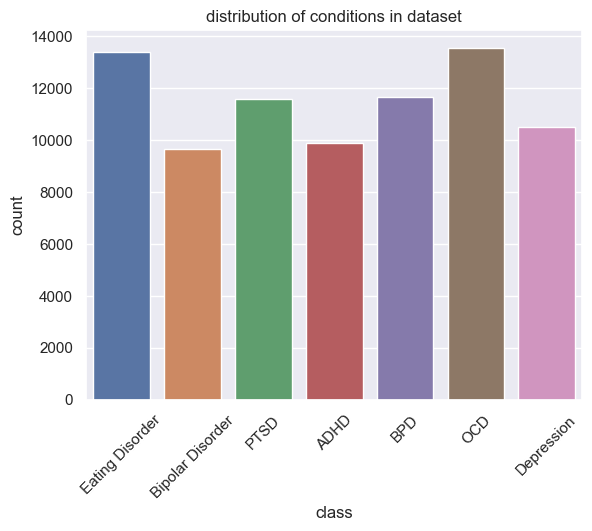

In [177]:
#expecting data to be fairly balanced since we extracted the same number of docs for each
sns.countplot(train, x = 'class')
plt.title('distribution of conditions in dataset')
plt.xticks(rotation =45)
plt.show()

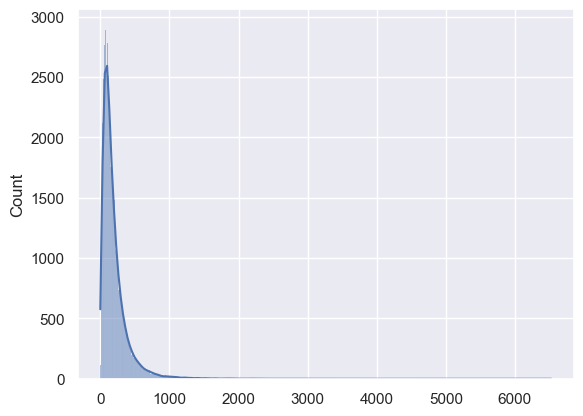

In [167]:
#Explore the avg. length of docs 
doc_len = [len(word_tokenize(doc)) for doc in train['text']]
sns.histplot(doc_len, kde=True) 
plt.show()

as we can see most words look to be somewhere around 200 words with a few going up to a 1000 and then very few past this.
let us set xlimit to 600 so we can take a closer look at the distribution up to this point

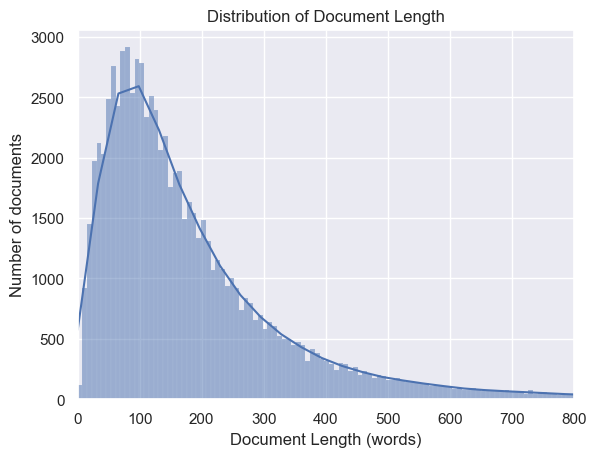

In [176]:
sns.histplot(doc_len, kde=True) 
plt.xlim(0,800)
plt.title('Distribution of Document Length')
plt.xlabel('Document Length (words)')
plt.ylabel('Number of documents')
plt.show()

Most docs are around 100 words, something to bear in mind when thinking about whether or not there is sufficient context for encoding/embedding layers.


In [161]:
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

stops = stopwords.words('english')
for word in STOP_WORDS:
    stops.append(word)

#not an exhaustive list, words that arise often which don't hold much meaning without context - 'wa' and 'ha' are lemmatized version of was and has, respectively
custom_stops = ['like', 'im', 'dont', 'want', 'feel', 'ive', 'think', 'know', 'thing', 'time', 'wa', 'ha']
for word in custom_stops:
    stops.append(word)

In [162]:
top_n = 5
for i in train['class'].unique():
    #clean remove stopwords from documents and lemmatize words to their root
    clean_docs = []
    vectorizer = TfidfVectorizer(stop_words=stops)
    docs = train[train['class']==i]['text']
    for doc in docs:
        lemma_doc = ' '.join([wnl.lemmatize(word) for word in word_tokenize(doc)])
        clean_docs.append(lemma_doc)
    #then tf-idf corpus grouped by class
    X = vectorizer.fit_transform(clean_docs)
    feature_array = vectorizer.get_feature_names_out()
    print(i)
    print('Frequency: \n', sorted(list(zip(vectorizer.get_feature_names_out(), 
                                         X.sum(0).getA1())),
                            key=lambda x: x[1], reverse=True)[:top_n])


Eating Disorder
Frequency: 
 [('weight', 421.5279075055693), ('eat', 392.8750540042897), ('eating', 355.4109689595481), ('food', 344.5163979969004), ('ed', 326.4535147300706)]
Bipolar Disorder
Frequency: 
 [('bipolar', 295.9316336591282), ('episode', 230.64462681589364), ('med', 221.81846328199418), ('day', 221.57725794853818), ('manic', 206.0597167747301)]
PTSD
Frequency: 
 [('ptsd', 415.16946703104406), ('year', 301.731624544457), ('trauma', 279.6249740424151), ('people', 264.5776812811203), ('help', 254.33902002333573)]
ADHD
Frequency: 
 [('adhd', 420.8880660094775), ('day', 267.5706833490864), ('work', 244.56071819596096), ('medication', 220.53593735687886), ('med', 210.59303592171807)]
BPD
Frequency: 
 [('bpd', 407.86862133340753), ('friend', 337.8166979379144), ('people', 330.5699331369621), ('relationship', 274.4864518693749), ('feeling', 270.1402204209334)]
OCD
Frequency: 
 [('ocd', 708.1151123485838), ('thought', 574.8382238528977), ('intrusive', 291.3158026065959), ('help', 2

## 3. Prepare data for spacy model 🪐

Data is nice and tidy now, we have our `text` column and we have our `class` column, which as we can see assigns **one** label per document. 

The text categorizer is a model that predicts categories over a whole document. SpaCy provides a readymade version of this model in two flavors: `textcat` and `textcat_multilabel`.

When you need to predict exactly one true label per document, use the `textcat` which has mutually exclusive labels. If you want to perform multi-label classification and predict zero, one or more true labels per document, use the `textcat_multilabel` component instead.

Each post can only belong to one subreddit (which we have leveraged as the class field here) and thus we will be treating documents as having mutually exclusive labels. This is slightly inaccurate as a user can definltely talk about more than one condition in a post. However, manually labelling a sufficiently large subset of data to reflect this would be extremely time-consuming and subjective.

Predictions will be saved to `doc.cats` as a dictionary, where the key is the name of the category and the value is a score between 0 and 1 (inclusive).

For `textcat`, missing values are equated to a value of 0 (i.e. False) and are counted as such towards the loss and scoring metrics.

In [5]:
#if you've already made cleaned dataset
df = pd.read_csv('assets/cleaned_reddit_dataset.csv', index_col = 0)
df.head()

,text,class
0,is there something wrong with me? i'm a gradua...,Depression
2,why are some people so against the idea of sui...,Depression
3,i'm almost ready to give up everything i care ...,Depression
4,fuck andrew tate this guy says depression is a...,Depression
6,facial scar ruined my life. me[28 m] i had an ...,Depression


In [6]:
# we need to firstly convert train and development sets into Spacy docs and then manually specify the categories in a dict for each doc.
nlp = spacy.load('en_core_web_lg')                                              

In [7]:
def get_cat_dict(data):
    data = [(row['text'], row['class']) for idx, row in data.iterrows()]
    cat_dict_list = []
    for doc, label in nlp.pipe(data, as_tuples=True):
      label_dict = {'Depression': 0,
      'PTSD':0,
      'OCD': 0,
      'Eating Disorder': 0,
      'Bipolar Disorder':0,
      'BPD':0,
      'ADHD': 0}
      label_dict[label] = 1
      cat_dict_list.append(label_dict)
    return (cat_dict_list)


In [ ]:
#Convert class col into binary dict
train['class'] = get_cat_dict(train)

#do same for validation + test data
dev['class'] = get_cat_dict(dev)    
test['class'] = get_cat_dict(test)                                            

In [ ]:
train.to_csv('assets/reddit-train.csv')
dev.to_csv('assets/reddit-dev.csv')
test.to_csv('assets/reddit-test.csv')

In [ ]:
#convert training and validation data into jsonl files
train.to_json('assets/reddit-train.jsonl', orient = 'records', lines=True)

#these will be fed to the convert function of pipeline
dev.to_json('assets/reddit-dev.jsonl', orient = 'records', lines = True)

test.to_json('assets/reddit-test.jsonl', orient = 'records', lines = True)

## 4.Model configuration
We have all our data, and it is now ready to give to SpaCy. The next important step is to configure a SpaCy model to our specific use case. In order to do this it will be helpful to explore the data a little bit and get a feel for it.

Model configuration is not done throught Python, I have specified and provided a brief justification of the configuration in the `base_config.cfg` file in the `configs` folder of this repo.